# **Multivariate Time Series Forecasting of Wheat Yield in Australia Using LSTM**

This notebook shows the code for my Final Year Project: *Actuaries Climate Index and Multivariate Wheat Yield Modelling: A Comparison of VAR and LSTM* 

In [1]:
import os
os.getcwd()

'/home/matthewfarant123/apu-fyp'

# Data Pre-Processing

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from scipy import interpolate
from pandasql import sqldf

In [3]:
#Import The Australian Actuaries Climate Index (AACI) Dataset

df_all = pd.read_csv('/home/matthewfarant123/apu-fyp/datasets/aaci_australia.csv')
df_cdd = pd.read_csv('/home/matthewfarant123/apu-fyp/datasets/aaci_cdd_australia.csv')
df_rainfall = pd.read_csv('/home/matthewfarant123/apu-fyp/datasets/aaci_rainfall_australia.csv')
df_sealevel = pd.read_csv('/home/matthewfarant123/apu-fyp/datasets/aaci_sealevel_australia.csv')
df_temphigh = pd.read_csv('/home/matthewfarant123/apu-fyp/datasets/aaci_temphigh_australia.csv')
df_templow = pd.read_csv('/home/matthewfarant123/apu-fyp/datasets/aaci_templow_australia.csv')
df_wind = pd.read_csv('/home/matthewfarant123/apu-fyp/datasets/aaci_wind_australia.csv')

In [4]:
#Transpose the AACI data
sqlkey = lambda q : sqldf(q,globals())
query = '''
WITH grouped AS (
  -- ALL
  SELECT Year,
    Region || '_ALL' Region,
    AVG(AACI) AS AACI
  FROM df_all
  GROUP BY 1,2

  UNION ALL
  -- CDD
  SELECT Year,
    Region || '_CDD' Region,
    AVG(AACI) AS AACI
  FROM df_cdd
  GROUP BY 1,2

  UNION ALL
  --RAINFALL
  SELECT Year,
    Region || '_RF' Region,
    AVG(AACI) AS AACI
  FROM df_rainfall
  GROUP BY 1,2

  UNION ALL
  --SEALEVEL
  SELECT Year,
    Region || '_SL' Region,
    AVG(AACI) AS AACI
  FROM df_sealevel
  GROUP BY 1,2

  UNION ALL
  --TEMPHIGH
  SELECT Year,
    Region || '_TH' Region,
    AVG(AACI) AS AACI
  FROM df_temphigh
  GROUP BY 1,2

  UNION ALL
  --TEMPLOW
  SELECT Year,
    Region || '_TL' Region,
    AVG(AACI) AS AACI
  FROM df_templow
  GROUP BY 1,2

  UNION ALL
  --WIND
  SELECT Year,
    Region || '_WI' Region,
    AVG(AACI) AS AACI
  FROM df_wind
  GROUP BY 1,2
), 
transposed AS (
  SELECT Year,
    --ALL
    CASE WHEN Region = 'AU_ALL' THEN AACI END AS AU_ALL,
    CASE WHEN Region = 'CS_ALL' THEN AACI END AS CS_ALL,
    CASE WHEN Region = 'EN_ALL' THEN AACI END AS EN_ALL,
    CASE WHEN Region = 'ES_ALL' THEN AACI END AS ES_ALL,
    CASE WHEN Region = 'MB_ALL' THEN AACI END AS MB_ALL,
    CASE WHEN Region = 'MN_ALL' THEN AACI END AS MN_ALL,
    CASE WHEN Region = 'RN_ALL' THEN AACI END AS RN_ALL,
    CASE WHEN Region = 'RS_ALL' THEN AACI END AS RS_ALL,
    CASE WHEN Region = 'SE_ALL' THEN AACI END AS SE_ALL,
    CASE WHEN Region = 'ST_ALL' THEN AACI END AS ST_ALL,
    CASE WHEN Region = 'SV_ALL' THEN AACI END AS SV_ALL,
    CASE WHEN Region = 'SW_ALL' THEN AACI END AS SW_ALL,
    CASE WHEN Region = 'WT_ALL' THEN AACI END AS WT_ALL,
    --CDD
    CASE WHEN Region = 'AU_CDD' THEN AACI END AS AU_CDD,
    CASE WHEN Region = 'CS_CDD' THEN AACI END AS CS_CDD,
    CASE WHEN Region = 'EN_CDD' THEN AACI END AS EN_CDD,
    CASE WHEN Region = 'ES_CDD' THEN AACI END AS ES_CDD,
    CASE WHEN Region = 'MB_CDD' THEN AACI END AS MB_CDD,
    CASE WHEN Region = 'MN_CDD' THEN AACI END AS MN_CDD,
    CASE WHEN Region = 'RN_CDD' THEN AACI END AS RN_CDD,
    CASE WHEN Region = 'RS_CDD' THEN AACI END AS RS_CDD,
    CASE WHEN Region = 'SE_CDD' THEN AACI END AS SE_CDD,
    CASE WHEN Region = 'ST_CDD' THEN AACI END AS ST_CDD,
    CASE WHEN Region = 'SV_CDD' THEN AACI END AS SV_CDD,
    CASE WHEN Region = 'SW_CDD' THEN AACI END AS SW_CDD,
    CASE WHEN Region = 'WT_CDD' THEN AACI END AS WT_CDD,
    --RAINFALL
    CASE WHEN Region = 'AU_RF' THEN AACI END AS AU_RF,
    CASE WHEN Region = 'CS_RF' THEN AACI END AS CS_RF,
    CASE WHEN Region = 'EN_RF' THEN AACI END AS EN_RF,
    CASE WHEN Region = 'ES_RF' THEN AACI END AS ES_RF,
    CASE WHEN Region = 'MB_RF' THEN AACI END AS MB_RF,
    CASE WHEN Region = 'MN_RF' THEN AACI END AS MN_RF,
    CASE WHEN Region = 'RN_RF' THEN AACI END AS RN_RF,
    CASE WHEN Region = 'RS_RF' THEN AACI END AS RS_RF,
    CASE WHEN Region = 'SE_RF' THEN AACI END AS SE_RF,
    CASE WHEN Region = 'ST_RF' THEN AACI END AS ST_RF,
    CASE WHEN Region = 'SV_RF' THEN AACI END AS SV_RF,
    CASE WHEN Region = 'SW_RF' THEN AACI END AS SW_RF,
    CASE WHEN Region = 'WT_RF' THEN AACI END AS WT_RF,
    --SEALEVEL
    CASE WHEN Region = 'AU_SL' THEN AACI END AS AU_SL,
    CASE WHEN Region = 'CS_SL' THEN AACI END AS CS_SL,
    CASE WHEN Region = 'EN_SL' THEN AACI END AS EN_SL,
    CASE WHEN Region = 'ES_SL' THEN AACI END AS ES_SL,
    CASE WHEN Region = 'MB_SL' THEN AACI END AS MB_SL,
    CASE WHEN Region = 'MN_SL' THEN AACI END AS MN_SL,
    CASE WHEN Region = 'RN_SL' THEN AACI END AS RN_SL,
    CASE WHEN Region = 'RS_SL' THEN AACI END AS RS_SL,
    CASE WHEN Region = 'SE_SL' THEN AACI END AS SE_SL,
    CASE WHEN Region = 'ST_SL' THEN AACI END AS ST_SL,
    CASE WHEN Region = 'SV_SL' THEN AACI END AS SV_SL,
    CASE WHEN Region = 'SW_SL' THEN AACI END AS SW_SL,
    CASE WHEN Region = 'WT_SL' THEN AACI END AS WT_SL,
    --TEMPHIGH
    CASE WHEN Region = 'AU_TH' THEN AACI END AS AU_TH,
    CASE WHEN Region = 'CS_TH' THEN AACI END AS CS_TH,
    CASE WHEN Region = 'EN_TH' THEN AACI END AS EN_TH,
    CASE WHEN Region = 'ES_TH' THEN AACI END AS ES_TH,
    CASE WHEN Region = 'MB_TH' THEN AACI END AS MB_TH,
    CASE WHEN Region = 'MN_TH' THEN AACI END AS MN_TH,
    CASE WHEN Region = 'RN_TH' THEN AACI END AS RN_TH,
    CASE WHEN Region = 'RS_TH' THEN AACI END AS RS_TH,
    CASE WHEN Region = 'SE_TH' THEN AACI END AS SE_TH,
    CASE WHEN Region = 'ST_TH' THEN AACI END AS ST_TH,
    CASE WHEN Region = 'SV_TH' THEN AACI END AS SV_TH,
    CASE WHEN Region = 'SW_TH' THEN AACI END AS SW_TH,
    CASE WHEN Region = 'WT_TH' THEN AACI END AS WT_TH,
    --TEMPLOW
    CASE WHEN Region = 'AU_TL' THEN AACI END AS AU_TL,
    CASE WHEN Region = 'CS_TL' THEN AACI END AS CS_TL,
    CASE WHEN Region = 'EN_TL' THEN AACI END AS EN_TL,
    CASE WHEN Region = 'ES_TL' THEN AACI END AS ES_TL,
    CASE WHEN Region = 'MB_TL' THEN AACI END AS MB_TL,
    CASE WHEN Region = 'MN_TL' THEN AACI END AS MN_TL,
    CASE WHEN Region = 'RN_TL' THEN AACI END AS RN_TL,
    CASE WHEN Region = 'RS_TL' THEN AACI END AS RS_TL,
    CASE WHEN Region = 'SE_TL' THEN AACI END AS SE_TL,
    CASE WHEN Region = 'ST_TL' THEN AACI END AS ST_TL,
    CASE WHEN Region = 'SV_TL' THEN AACI END AS SV_TL,
    CASE WHEN Region = 'SW_TL' THEN AACI END AS SW_TL,
    CASE WHEN Region = 'WT_TL' THEN AACI END AS WT_TL,
    --WIND
    CASE WHEN Region = 'AU_WI' THEN AACI END AS AU_WI,
    CASE WHEN Region = 'CS_WI' THEN AACI END AS CS_WI,
    CASE WHEN Region = 'EN_WI' THEN AACI END AS EN_WI,
    CASE WHEN Region = 'ES_WI' THEN AACI END AS ES_WI,
    CASE WHEN Region = 'MB_WI' THEN AACI END AS MB_WI,
    CASE WHEN Region = 'MN_WI' THEN AACI END AS MN_WI,
    CASE WHEN Region = 'RN_WI' THEN AACI END AS RN_WI,
    CASE WHEN Region = 'RS_WI' THEN AACI END AS RS_WI,
    CASE WHEN Region = 'SE_WI' THEN AACI END AS SE_WI,
    CASE WHEN Region = 'ST_WI' THEN AACI END AS ST_WI,
    CASE WHEN Region = 'SV_WI' THEN AACI END AS SV_WI,
    CASE WHEN Region = 'SW_WI' THEN AACI END AS SW_WI,
    CASE WHEN Region = 'WT_WI' THEN AACI END AS WT_WI
  FROM grouped
)
SELECT Year,
    --ALL
      SUM(AU_ALL) AS AU_ALL,
      SUM(CS_ALL) AS CS_ALL,
      SUM(EN_ALL) AS EN_ALL,
      SUM(ES_ALL) AS ES_ALL,
      SUM(MB_ALL) AS MB_ALL,
      SUM(MN_ALL) AS MN_ALL,
      SUM(RN_ALL) AS RN_ALL,
      SUM(RS_ALL) AS RS_ALL,
      SUM(SE_ALL) AS SE_ALL,
      SUM(ST_ALL) AS ST_ALL,
      SUM(SV_ALL) AS SV_ALL,
      SUM(SW_ALL) AS SW_ALL,
      SUM(WT_ALL) AS WT_ALL,
    --CDD
      SUM(AU_CDD) AS AU_CDD,
      SUM(CS_CDD) AS CS_CDD,
      SUM(EN_CDD) AS EN_CDD,
      SUM(ES_CDD) AS ES_CDD,
      SUM(MB_CDD) AS MB_CDD,
      SUM(MN_CDD) AS MN_CDD,
      SUM(RN_CDD) AS RN_CDD,
      SUM(RS_CDD) AS RS_CDD,
      SUM(SE_CDD) AS SE_CDD,
      SUM(ST_CDD) AS ST_CDD,
      SUM(SV_CDD) AS SV_CDD,
      SUM(SW_CDD) AS SW_CDD,
      SUM(WT_CDD) AS WT_CDD,
    --RAINFALL
      SUM(AU_RF) AS AU_RF,
      SUM(CS_RF) AS CS_RF,
      SUM(EN_RF) AS EN_RF,
      SUM(ES_RF) AS ES_RF,
      SUM(MB_RF) AS MB_RF,
      SUM(MN_RF) AS MN_RF,
      SUM(RN_RF) AS RN_RF,
      SUM(RS_RF) AS RS_RF,
      SUM(SE_RF) AS SE_RF,
      SUM(ST_RF) AS ST_RF,
      SUM(SV_RF) AS SV_RF,
      SUM(SW_RF) AS SW_RF,
      SUM(WT_RF) AS WT_RF,
    --SEALEVEL
      SUM(AU_SL) AS AU_SL,
      SUM(CS_SL) AS CS_SL,
      SUM(EN_SL) AS EN_SL,
      SUM(ES_SL) AS ES_SL,
      SUM(MB_SL) AS MB_SL,
      SUM(MN_SL) AS MN_SL,
      SUM(RN_SL) AS RN_SL,
      SUM(RS_SL) AS RS_SL,
      SUM(SE_SL) AS SE_SL,
      SUM(ST_SL) AS ST_SL,
      SUM(SV_SL) AS SV_SL,
      SUM(SW_SL) AS SW_SL,
      SUM(WT_SL) AS WT_SL,
    --TEMPHIGH
      SUM(AU_TH) AS AU_TH,
      SUM(CS_TH) AS CS_TH,
      SUM(EN_TH) AS EN_TH,
      SUM(ES_TH) AS ES_TH,
      SUM(MB_TH) AS MB_TH,
      SUM(MN_TH) AS MN_TH,
      SUM(RN_TH) AS RN_TH,
      SUM(RS_TH) AS RS_TH,
      SUM(SE_TH) AS SE_TH,
      SUM(ST_TH) AS ST_TH,
      SUM(SV_TH) AS SV_TH,
      SUM(SW_TH) AS SW_TH,
      SUM(WT_TH) AS WT_TH,
    --TEMPLOW
      SUM(AU_TL) AS AU_TL,
      SUM(CS_TL) AS CS_TL,
      SUM(EN_TL) AS EN_TL,
      SUM(ES_TL) AS ES_TL,
      SUM(MB_TL) AS MB_TL,
      SUM(MN_TL) AS MN_TL,
      SUM(RN_TL) AS RN_TL,
      SUM(RS_TL) AS RS_TL,
      SUM(SE_TL) AS SE_TL,
      SUM(ST_TL) AS ST_TL,
      SUM(SV_TL) AS SV_TL,
      SUM(SW_TL) AS SW_TL,
      SUM(WT_TL) AS WT_TL,
    --WIND
      SUM(AU_WI) AS AU_WI,
      SUM(CS_WI) AS CS_WI,
      SUM(EN_WI) AS EN_WI,
      SUM(ES_WI) AS ES_WI,
      SUM(MB_WI) AS MB_WI,
      SUM(MN_WI) AS MN_WI,
      SUM(RN_WI) AS RN_WI,
      SUM(RS_WI) AS RS_WI,
      SUM(SE_WI) AS SE_WI,
      SUM(ST_WI) AS ST_WI,
      SUM(SV_WI) AS SV_WI,
      SUM(SW_WI) AS SW_WI,
      SUM(WT_WI) AS WT_WI
FROM transposed
GROUP BY Year
;
'''
df_final = sqlkey(query)

In [5]:
df_final.head()

,Year,AU_ALL,CS_ALL,EN_ALL,ES_ALL,MB_ALL,MN_ALL,RN_ALL,RS_ALL,SE_ALL,...,ES_WI,MB_WI,MN_WI,RN_WI,RS_WI,SE_WI,ST_WI,SV_WI,SW_WI,WT_WI
0,1981,-0.087208,-0.084951,-0.258811,0.087191,-0.041700,-0.158683,-0.012887,-0.111130,-0.007505,...,0.000000,0.000000,0.000000,0.000000,0.00000,-0.013465,-0.715201,0.000000,0.000000,0.000000
1,1982,-0.357338,-0.196937,-0.433829,-0.108388,-0.010522,-0.538458,-0.211941,-0.156131,-0.452043,...,0.000000,0.000000,0.000000,0.000000,0.00000,-0.641513,0.043719,0.000000,0.000000,0.000000
2,1983,0.064702,0.259954,0.297082,-0.146317,0.242856,-0.069399,0.022740,-0.165062,0.018552,...,1.198097,0.206157,0.000000,0.000000,0.00000,0.717042,0.207227,0.000000,-0.286570,0.000000
3,1984,-0.141534,-0.128566,-0.025731,0.142605,-0.161209,-0.166435,-0.130824,0.011527,-0.410279,...,-0.283743,0.324074,0.000000,0.294304,0.00000,0.605802,0.545126,-0.401749,-0.011464,-0.091303
4,1985,-0.121609,-0.338231,-0.382139,-0.020478,-0.130815,-0.258032,-0.040343,-0.059485,-0.123720,...,0.134474,-0.391836,0.490319,0.362322,-0.13024,-0.046661,-0.161557,0.138516,0.415375,1.027355


In [6]:
#Exclude 2021 Data
aaci = df_final[(df_final.Year != 2021)]

In [8]:
#Import the Wheat Yield Dataset
wheat = pd.read_csv('/home/matthewfarant123/apu-fyp/datasets/wheat_data.csv')

In [9]:
#Join the AACI and Wheat Yield Dataset
query = '''
  WITH CTE AS (
  SELECT b.Year,Yield,
AU_ALL,
CS_ALL,
EN_ALL,
ES_ALL,
MB_ALL,
MN_ALL,
RN_ALL,
RS_ALL,
SE_ALL,
ST_ALL,
SV_ALL,
SW_ALL,
WT_ALL,
AU_CDD,
CS_CDD,
EN_CDD,
ES_CDD,
MB_CDD,
MN_CDD,
RN_CDD,
RS_CDD,
SE_CDD,
ST_CDD,
SV_CDD,
SW_CDD,
WT_CDD,
AU_RF,
CS_RF,
EN_RF,
ES_RF,
MB_RF,
MN_RF,
RN_RF,
RS_RF,
SE_RF,
ST_RF,
SV_RF,
SW_RF,
WT_RF,
AU_SL,
CS_SL,
EN_SL,
ES_SL,
MB_SL,
MN_SL,
RN_SL,
RS_SL,
SE_SL,
ST_SL,
SV_SL,
SW_SL,
WT_SL,
AU_TH,
CS_TH,
EN_TH,
ES_TH,
MB_TH,
MN_TH,
RN_TH,
RS_TH,
SE_TH,
ST_TH,
SV_TH,
SW_TH,
WT_TH,
AU_TL,
CS_TL,
EN_TL,
ES_TL,
MB_TL,
MN_TL,
RN_TL,
RS_TL,
SE_TL,
ST_TL,
SV_TL,
SW_TL,
WT_TL,
AU_WI,
CS_WI,
EN_WI,
ES_WI,
MB_WI,
MN_WI,
RN_WI,
RS_WI,
SE_WI,
ST_WI,
SV_WI,
SW_WI,
WT_WI
  FROM wheat b
  LEFT JOIN aaci a
  ON a.Year = b.Year
  )
  SELECT *
  FROM CTE
  -- WHERE Year<2020
    '''
final_data = sqlkey(query)

In [10]:
final_data = final_data.set_index('Year')
#final_data['Year'] = final_data.index

In [11]:
final_data.head()

,Yield,AU_ALL,CS_ALL,EN_ALL,ES_ALL,MB_ALL,MN_ALL,RN_ALL,RS_ALL,SE_ALL,...,ES_WI,MB_WI,MN_WI,RN_WI,RS_WI,SE_WI,ST_WI,SV_WI,SW_WI,WT_WI
Year,,,,,,,,,,,,,,,,,,,,,
1981,1.376496,-0.087208,-0.084951,-0.258811,0.087191,-0.041700,-0.158683,-0.012887,-0.111130,-0.007505,...,0.000000,0.000000,0.000000,0.000000,0.00000,-0.013465,-0.715201,0.000000,0.000000,0.000000
1982,0.764317,-0.357338,-0.196937,-0.433829,-0.108388,-0.010522,-0.538458,-0.211941,-0.156131,-0.452043,...,0.000000,0.000000,0.000000,0.000000,0.00000,-0.641513,0.043719,0.000000,0.000000,0.000000
1983,1.624118,0.064702,0.259954,0.297082,-0.146317,0.242856,-0.069399,0.022740,-0.165062,0.018552,...,1.198097,0.206157,0.000000,0.000000,0.00000,0.717042,0.207227,0.000000,-0.286570,0.000000
1984,1.500378,-0.141534,-0.128566,-0.025731,0.142605,-0.161209,-0.166435,-0.130824,0.011527,-0.410279,...,-0.283743,0.324074,0.000000,0.294304,0.00000,0.605802,0.545126,-0.401749,-0.011464,-0.091303
1985,1.368707,-0.121609,-0.338231,-0.382139,-0.020478,-0.130815,-0.258032,-0.040343,-0.059485,-0.123720,...,0.134474,-0.391836,0.490319,0.362322,-0.13024,-0.046661,-0.161557,0.138516,0.415375,1.027355


In [234]:
final_data.to_csv('/home/matthewfarant123/apu-fyp/final_data.csv')

# Exploratory Data Analysis

The Dependent Variable: Wheat Yield

/home/matthewfarant123/fyp_venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


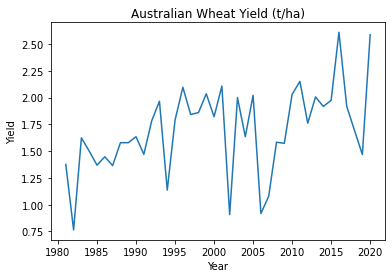

In [257]:
original = final_data[['Year', 'Yield']]
sn.lineplot(original['Year'], original['Yield'])
plt.title('Australian Wheat Yield (t/ha)')
plt.ioff()

Summary

In [259]:
final_data.describe()

,Yield,AU_ALL,CS_ALL,EN_ALL,ES_ALL,MB_ALL,MN_ALL,RN_ALL,RS_ALL,SE_ALL,...,ES_WI,MB_WI,MN_WI,RN_WI,RS_WI,SE_WI,ST_WI,SV_WI,SW_WI,WT_WI
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,...,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,1.699264,0.103778,0.104966,0.147466,0.107430,0.082501,0.082234,0.140301,0.083536,0.079385,...,0.006500,-0.050879,0.067831,-0.069410,-0.009495,-0.143772,0.007333,-0.040205,-0.096069,-0.103899
std,0.405127,0.246139,0.322618,0.383977,0.306619,0.235823,0.316262,0.362563,0.222652,0.292806,...,0.501714,0.341806,0.265681,0.212533,0.200427,0.531428,0.450955,0.424660,0.339861,0.365725
min,0.764317,-0.357338,-0.338231,-0.465697,-0.458022,-0.289545,-0.538458,-0.580156,-0.165062,-0.452043,...,-0.851683,-0.818370,-0.405833,-0.535596,-0.418297,-1.225444,-0.966398,-0.842845,-0.800303,-0.681513
25%,1.469348,-0.061992,-0.120781,-0.137139,-0.035045,-0.080400,-0.140351,-0.088925,-0.052139,-0.121184,...,-0.285168,-0.198445,-0.023995,-0.188076,-0.115443,-0.391016,-0.173355,-0.267295,-0.360390,-0.397172
50%,1.726303,0.068389,0.043390,0.129903,0.089154,-0.007452,0.032646,0.078232,0.013456,0.005524,...,0.000000,-0.013759,0.000000,0.000000,0.000000,-0.026186,0.000000,0.000000,0.000000,0.000000
75%,1.980683,0.215775,0.259965,0.330542,0.257172,0.256259,0.231545,0.328915,0.167556,0.256328,...,0.136000,0.000000,0.131919,0.000000,0.044566,0.000000,0.183051,0.091730,0.020310,0.000000
max,2.609986,0.598915,1.080116,1.042626,1.086690,0.558293,0.892299,1.118792,0.870140,0.691664,...,1.511616,0.829485,0.875341,0.362322,0.459011,1.004991,1.058741,1.364023,0.782566,1.027355


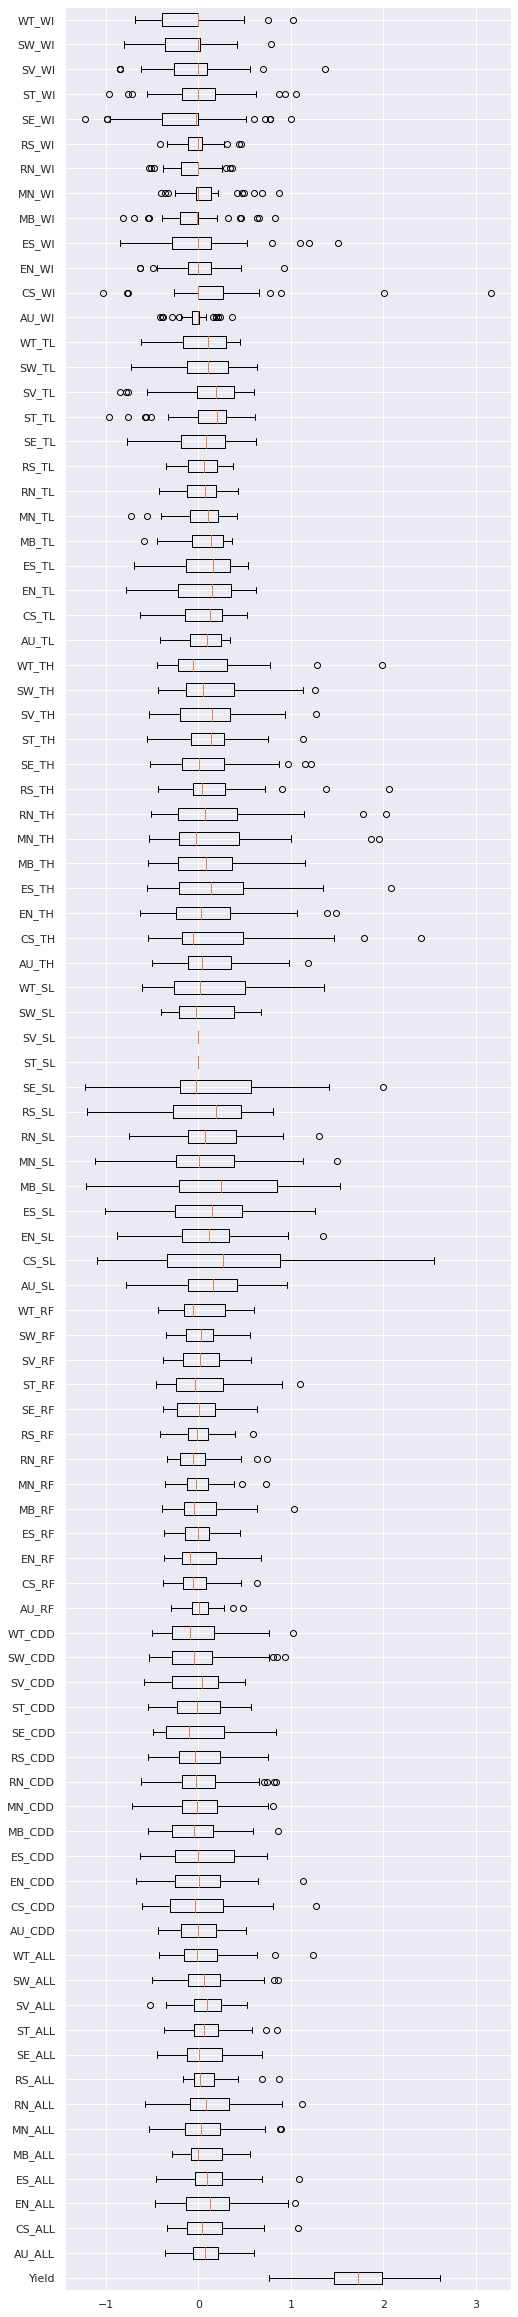

In [281]:
sn.set(rc={'figure.figsize':(8,42)})
plt.boxplot(final_data,vert=False)
plt.yticks(list(range(1,93)),list(final_data.columns))
plt.ioff()

Pandas Profiling

In [286]:
from pandas_profiling import ProfileReport

In [ ]:
profile = ProfileReport(final_data)
profile.to_file('EDA.html')

# Modelling


In [13]:
import tensorflow as tf
import hp
import keras
from kerastuner.tuners import BayesianOptimization
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error,r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

In [14]:
#Scaling The Data

scaler = StandardScaler()
scaled = scaler.fit_transform(final_data.values)
scaled[0]

array([-8.06857783e-01, -7.85812268e-01, -5.96172545e-01, -1.07155286e+00,
       -6.68477519e-02, -5.33380094e-01, -7.71471248e-01, -4.27896266e-01,
       -8.85442455e-01, -3.00530509e-01, -1.31110667e-01, -8.40321077e-01,
       -6.16524746e-01,  4.01336447e-01, -3.40624450e-01,  3.05610000e-01,
        3.66667025e-01,  1.26091549e+00, -1.06312378e+00, -6.93737632e-01,
       -5.63230511e-01,  8.07586599e-02, -1.25689849e+00, -1.65766226e+00,
        4.69463929e-01, -7.62374773e-01,  2.05662090e-01,  3.60656424e-01,
       -6.90723972e-02,  4.55166546e-01, -1.24998940e-03, -2.69826402e-01,
        1.39891891e+00,  6.44798079e-01, -9.01853889e-01,  3.55468452e-01,
        1.42733327e-01, -4.85079521e-01, -6.36394816e-01,  1.64944036e+00,
       -9.53366377e-01, -1.24835052e+00,  4.68271589e-01, -1.27980034e+00,
       -3.52800749e-01, -4.22446631e-01, -2.92728276e-01, -8.07666357e-01,
       -3.28309002e-01,  0.00000000e+00,  0.00000000e+00, -1.10331166e+00,
       -8.25582275e-01, -

In [15]:
#Convert into supervised form

def to_supervised(data,dropNa = True,lag = 1):
    df = pd.DataFrame(data)
    column = []
    column.append(df)
    for i in range(1,lag+1):
        column.append(df.shift(-i))
    df = pd.concat(column,axis=1)
    df.dropna(inplace = True)
    features = data.shape[1]
    df = df.values
    supervised_data = df[:,:features*lag]
    supervised_data = np.column_stack( [supervised_data, df[:,features*lag]])
    return supervised_data

In [16]:
# Using Lags

timeSteps = 5

supervised = to_supervised(scaled,lag=timeSteps)
pd.DataFrame(supervised).head()

,0,1,2,3,4,5,6,7,8,9,...,451,452,453,454,455,456,457,458,459,460
0,-0.806858,-0.785812,-0.596173,-1.071553,-0.066848,-0.533380,-0.771471,-0.427896,-0.885442,-0.300531,...,-1.010224,1.610470,2.057235,-0.610113,0.185064,-0.379286,0.426218,1.524034,3.132590,-0.629114
1,-2.337185,-1.897260,-0.947711,-1.533164,-0.712829,-0.399485,-1.987593,-0.983909,-1.090134,-1.838072,...,0.069217,0.049403,0.484673,-0.434349,-0.416426,0.775949,-0.503375,-1.220427,-0.398338,-0.836876
2,-0.187850,-0.160778,0.486527,0.394612,-0.838107,0.688643,-0.485563,-0.328380,-1.130755,-0.210406,...,-1.435234,0.085588,1.938522,-0.253155,-0.457527,-1.008052,0.040682,1.271272,2.358613,-0.301321
3,-0.497177,-1.009337,-0.733086,-0.456807,0.116182,-1.046610,-0.796293,-0.757326,-0.327536,-1.693621,...,-0.831663,-0.320844,-0.317692,-2.065643,0.084586,-1.727291,0.724375,0.110055,0.490997,-0.301303
4,-0.826327,-0.927356,-1.391250,-1.396830,-0.422471,-0.916080,-1.089609,-0.504588,-0.650535,-0.702487,...,-0.155783,-0.585720,-1.957148,-0.734671,-0.457527,0.140558,-1.914156,0.528354,1.604321,-0.162181


In [17]:
#Training and Testing Splitting

features = final_data.shape[1]
train_years = 25
X = supervised[:,:features*timeSteps]
y = supervised[:,features*timeSteps]

x_train = X[:train_years,:]
x_test = X[train_years:,:]
y_train = y[:train_years]
y_test = y[train_years:]

print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(25, 460) (10, 460) (25,) (10,)


In [18]:
#Convert Data Shape to Fit LSTM Model

x_train = x_train.reshape(x_train.shape[0], timeSteps, features)
x_test = x_test.reshape(x_test.shape[0], timeSteps, features)

print(x_train.shape,x_test.shape)

(25, 5, 92) (10, 5, 92)


Hyperparameter Tuning using Bayesian Optimization

In [41]:
def build(hp):
    activation = hp.Choice('activation', 
                        [
                          'relu',
                          'tanh',
                          'linear',
                          'selu',
                          'elu'
                        ])

    num_rnn_layers = hp.Int(
                        'num_rnn_layers', 
                        min_value=0,
                        max_value=12,
                        default=3)

    recurrent_dropout = hp.Float(
                        'recurrent_dropout', 
                        min_value=0.0,
                        max_value=0.5,
                        default=0.2)
    num_units = hp.Int(
                        'num_units', 
                        min_value=0,
                        max_value=64,
                        default=32)
    
    model = Sequential()
    model.add(LSTM(units=num_units, activation=activation, recurrent_dropout = recurrent_dropout,input_shape=( timeSteps,x_train.shape[2])))
    model.add(Dense(1))

    model.compile(
      optimizer=tf.keras.optimizers.Adam(
      hp.Float(
        'learning_rate',
        min_value=1e-10,
        max_value=1e-2,
        sampling='LOG',
        default=1e-4
            ),
        ),
        # loss=tf.losses.MeanSquaredError(),
        loss = 'mse',
        # metrics=[tf.metrics.MeanAbsoluteError()]
        metrics = ['mse']
    )
    return model

bayesian_opt_tuner = BayesianOptimization(
    build,
    objective='mse',
    max_trials=3,
    executions_per_trial=1,
    directory=os.path.normpath('/home/matthewfarant123/apu-fyp/keras-tuning'),
    project_name='kerastuner_bayesian_poc',
    overwrite=True)
n_epochs=100

bayesian_opt_tuner.search(x_train, y_train,epochs=n_epochs,
     validation_data=(x_test, y_test),
      batch_size=int(len(x_train)/2),
     validation_split=0.2,verbose=1)


bayes_opt_model_best_model = bayesian_opt_tuner.get_best_models(num_models=1)
model = bayes_opt_model_best_model[0]

Trial 3 Complete [00h 00m 12s]
mse: 0.00034235185012221336

Best mse So Far: 0.00034235185012221336
Total elapsed time: 00h 00m 37s
INFO:tensorflow:Oracle triggered exit


In [42]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                40192     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 40,257
Trainable params: 40,257
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
history =  model.fit( x_train,y_train,
                     validation_data = (x_test,y_test),
                     epochs = 100 ,
                     batch_size = 1,
                     callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
                     verbose = 0,
                     shuffle = False)

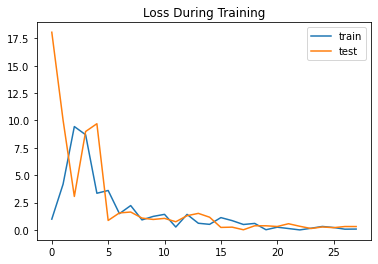

In [100]:
#Learning Curves

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("Loss During Training")
plt.show()

In [45]:
#Scaling Back the Wheat Yield Data to Original Scale

y_pred = model.predict(x_test)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[2]*x_test.shape[1])

inv_new = np.concatenate( (y_pred, x_test[:,-91:] ) , axis =1)
inv_new = scaler.inverse_transform(inv_new)
final_pred = inv_new[:,0]

y_test = y_test.reshape( len(y_test), 1)

inv_new = np.concatenate( (y_test, x_test[:,-91:] ) ,axis = 1)
inv_new = scaler.inverse_transform(inv_new)
actual_pred = inv_new[:,0]

In [55]:
#Predicted Year

df_forecast = pd.DataFrame({'Date':np.arange(start=2021-len(final_pred), stop=2021, step=1), 'Yield':final_pred})
df_forecast

,Date,Yield
0,2011,2.174445
1,2012,1.651292
2,2013,1.809923
3,2014,1.772661
4,2015,2.006571
5,2016,2.243110
6,2017,1.756282
7,2018,1.549646
8,2019,1.409169
9,2020,2.230486


In [47]:
final_data['Year'] = final_data.index

/home/matthewfarant123/fyp_venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/matthewfarant123/fyp_venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


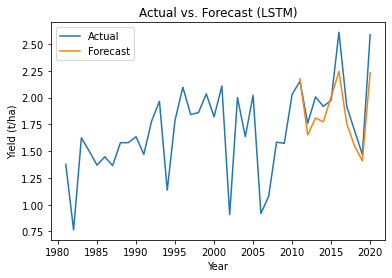

In [56]:
#Actual vs. Forecast Plot

original = final_data[['Year', 'Yield']]
sn.lineplot(original['Year'], original['Yield'],label='Actual').set(title='Actual vs. Forecast (LSTM)',ylabel='Yield (t/ha)')
sn.lineplot(df_forecast['Date'], df_forecast['Yield'],label='Forecast')
plt.legend(loc='upper left')
sn.lineplot()
plt.ioff()

In [57]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error,r2_score

print('MAE: '+ str(mean_absolute_error(final_pred,actual_pred)))
print('RMSE: '+ str(np.sqrt(mean_squared_error(final_pred,actual_pred))))
print('MAPE: '+ str(mean_absolute_percentage_error(final_pred,actual_pred)))

MAE: 0.159211466131598
RMSE: 0.1961116289736265
MAPE: 0.08321065675796067
